<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/pr_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=21b6668dd3e80ca11f6f3b80f0049093d98d5024218890d62d94f92bd325634f
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


Розмірність вхідних даних: (200, 2)

SOM навчена.


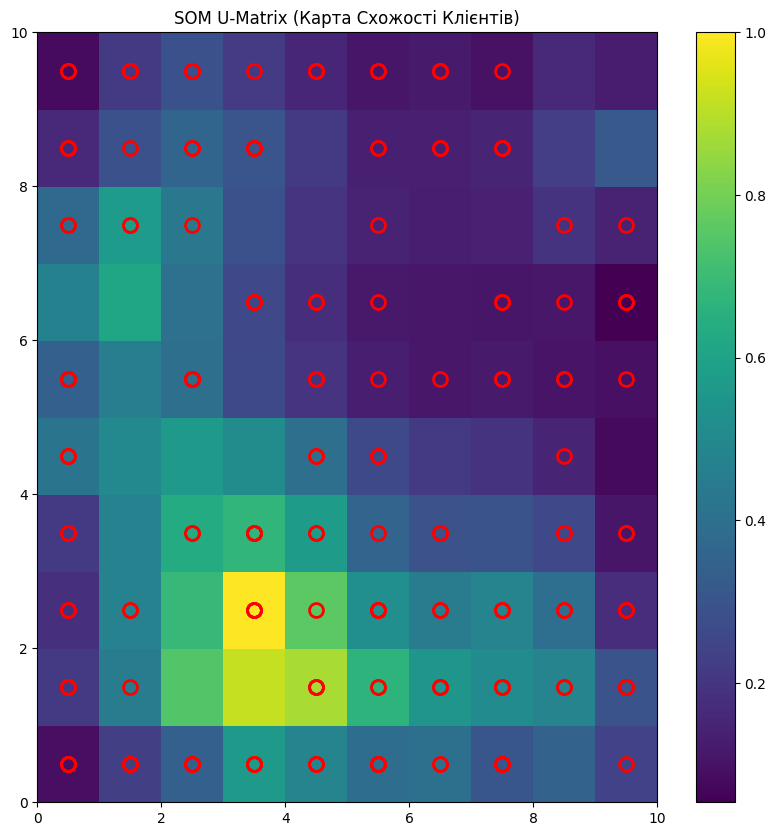

Карта схожості клієнтів (U-Matrix) візуалізована.


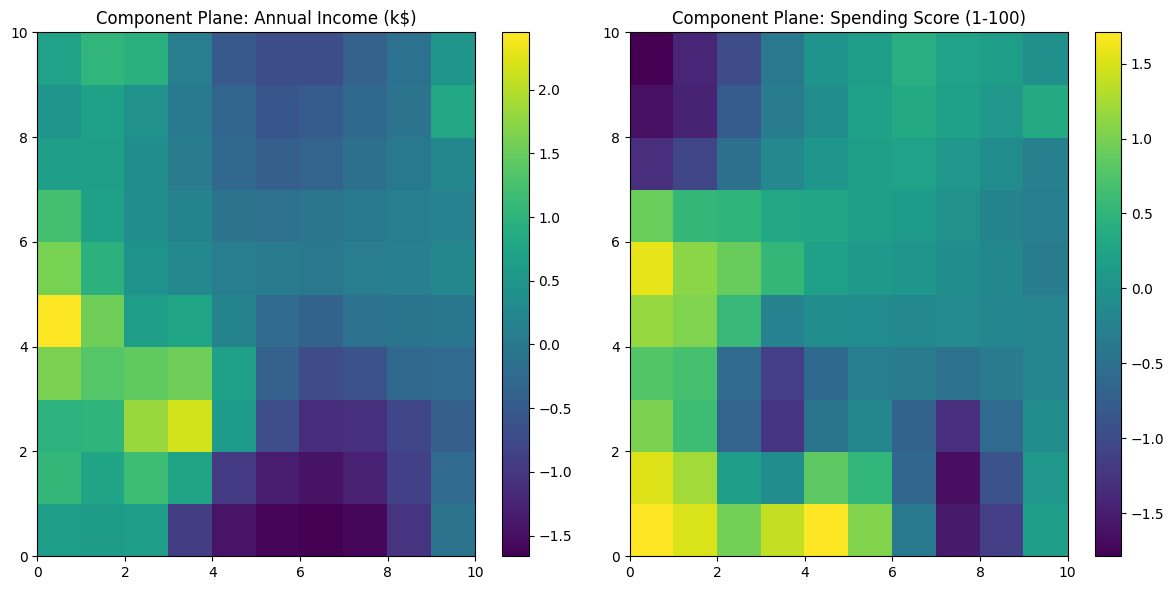

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show

# ЕТАП 1: ПІДГОТОВКА ДАНИХ
# ----------------------------------------------------------------------
# ПРИМІТКА: Припустимо, файл 'Mall_Customers.csv' знаходиться у тій же директорії.
try:
    data = pd.read_csv('Mall_Customers.csv')
except FileNotFoundError:
    print("Помилка: Файл 'Mall_Customers.csv' не знайдено. Переконайтеся, що ви його завантажили з Kaggle та помістили в поточну директорію.")
    exit()

# 1. Вибір та попередня обробка ознак
# Використовуємо 'Annual Income (k$)' та 'Spending Score (1-100)'
# Ці ознаки зазвичай дають найбільш виразну сегментацію в цьому датасеті.
# 'Age' також можна додати, але для кращої 2D візуалізації кластерів, часто використовують 2-3 основні ознаки.
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values

# 2. Нормалізація даних (критично важлива для SOM)
# Використовуємо StandardScaler, оскільки він центрує дані навколо 0 з одиничною дисперсією.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Розмірність вхідних даних: {X_scaled.shape}")

# ЕТАП 2: ПОБУДОВА ТА НАВЧАННЯ SOM
# ----------------------------------------------------------------------
# Визначення розмірності карти (наприклад, 10x10)
x_dim = 10
y_dim = 10
input_len = X_scaled.shape[1] # Кількість ознак (2)

# Ініціалізація та навчання SOM
som = MiniSom(
    x=x_dim,
    y=y_dim,
    input_len=input_len,
    sigma=1.0,           # Радіус сусідства
    learning_rate=0.5,   # Коефіцієнт навчання
    random_seed=42
)
som.random_weights_init(X_scaled)
# Навчання на 1000 ітераціях
som.train_random(data=X_scaled, num_iteration=1000, verbose=False)

print("\nSOM навчена.")

# ЕТАП 3: ВІЗУАЛІЗАЦІЯ U-MATRIX ТА СЕГМЕНТАЦІЯ
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 10))
# 1. U-Matrix (Карта відстаней)
bone()
pcolor(som.distance_map().T, cmap='viridis') # Відображення середніх відстаней між нейронами
colorbar()
plt.title('SOM U-Matrix (Карта Схожості Клієнтів)')

# 2. Візуалізація розподілу клієнтів (BMU)
# Нейрони-переможці (BMU) для кожного клієнта
for i, x in enumerate(X_scaled):
    w = som.winner(x)  # Знаходимо BMU
    # Додаємо маркер у центр нейрона-переможця
    # Використовуємо червоні кола для всіх клієнтів
    plot(w[0] + 0.5, w[1] + 0.5,
         'o',  # Коло
         markeredgecolor='r',
         markerfacecolor='None',
         markersize=10,
         markeredgewidth=2)

plt.show()
print("Карта схожості клієнтів (U-Matrix) візуалізована.")

# ЕТАП 4: АНАЛІЗ ОТРИМАНИХ СЕГМЕНТІВ ЗА ВАГАМИ НЕЙРОНІВ (Component Planes)
# ----------------------------------------------------------------------
# Візуалізація компонентних карт для розуміння характеристик сегментів
plt.figure(figsize=(12, 6))
feature_names = ['Annual Income (k$)', 'Spending Score (1-100)']

for i, feature_name in enumerate(feature_names):
    plt.subplot(1, 2, i + 1)
    plt.title(f'Component Plane: {feature_name}')
    # Відображення ваг нейронів для конкретної ознаки
    pcolor(som.get_weights()[:, :, i].T, cmap='viridis')
    colorbar()

plt.tight_layout()
plt.show()

# ЕТАП 5: ІНТЕРПРЕТАЦІЯ ТА ВИСНОВКИ (на основі U-Matrix та Component Planes)
# ----------------------------------------------------------------------

# Визначення кластерів на U-Matrix:
# Темні області U-Matrix представляють центри кластерів (схожі клієнти),
# Світлі області - межі між ними.
# Знайдемо BMU для кожного клієнта:
winner_coordinates = np.array([som.winner(x) for x in X_scaled]).T
# Кожен нейрон є центром потенційного сегмента.

